In [1]:
# Imports
%matplotlib inline

import sys
import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)

In [2]:
def create_sort_dataset(dataset_length, seq_length, max_number=999):
    x_train = np.random.randint(low=0, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_train = np.sort(x_train, axis=1)
    
    x_test = np.random.randint(low=0, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_test = np.sort(x_test, axis=1)
    
    return x_train, y_train, x_test, y_test

In [7]:
def cross_entropy(Y, T):
    # Y (batch_size, seq_length, num_of_classes)
    # T (batch_size, seq_length, 1)

    print(f"Y.shape {Y.shape}")
    print(f"T.shape {T.shape}")
    m = T.shape[1]
    #ps = self.forward(Y, axis=2)

    losses = []
    for idx, p in enumerate(Y):  
        log_likelihood = -np.log(p[range(m), T[idx]])
        loss = np.sum(log_likelihood) / m
        losses.append(loss)
    return np.mean(losses)

In [8]:
y_pred = RNN.getOutput(X_mb)
cross_entropy(y_pred, T_mb)

Y.shape (20, 7, 5)
T.shape (20, 7, 1)


12.97725612137836

In [9]:
RNN.loss(y_pred, T_mb)

12.97725612137836

In [10]:
RNN.classifier.old_loss(y_pred, T_mb)

-7.000000575682596e-09

In [3]:
# Define the linear tensor transformation layer
class TensorLinear(object):
    """The linear tensor layer applies a linear tensor dot product 
    and a bias to its input."""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        """Initialse the weight W and bias b parameters."""
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        # Axes summed over in backprop
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        """Perform forward step transformation with the help 
        of a tensor product."""
        # Same as: Y[i,j,:] = np.dot(X[i,j,:], self.W) + self.b 
        #          (for i,j in X.shape[0:1])
        # Same as: Y = np.einsum('ijk,kl->ijl', X, self.W) + self.b
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Same as: gW = np.einsum('ijk,ijl->kl', X, gY)
        # Same as: gW += np.dot(X[:,j,:].T, gY[:,j,:]) 
        #          (for i,j in X.shape[0:1])
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        # Same as: gX = np.einsum('ijk,kl->ijl', gY, self.W.T)
        # Same as: gX[i,j,:] = np.dot(gY[i,j,:], self.W.T) 
        #          (for i,j in gY.shape[0:1])
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB

# Define the logistic classifier layer
class LogisticClassifier(object):
    """The logistic layer applies the logistic function to its 
    inputs."""
   
    def forward(self, X):
        """Perform the forward step transformation."""
        return 1. / (1. + np.exp(-X))
    
    def backward(self, Y, T):
        """Return the gradient with respect to the loss function 
        at the inputs of this layer."""
        # Average by the number of samples and sequence length.
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y, T):
        """Compute the loss at the output."""
        return -np.mean((T * np.log(Y)) + ((1-T) * np.log(1-Y)))

class LogisticClassifierSoftmax:
    def forward(self, X, theta = 1.0, axis = 2):
        "Takes X as 3d tensor"
        y = np.atleast_2d(X)
        # find axis

        if axis is None:
            axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

        # multiply y against the theta parameter,
        y = y * float(theta)
        # subtract the max for numerical stability
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        # exponentiate y
        y = np.exp(y)
        # take the sum along the specified axis
        ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
        # finally: divide elementwise
        p = y / ax_sum

        # flatten if X was 1D
        if len(X.shape) == 1: p = p.flatten()

        return p
        
    def loss(self, Y, T):
        """
        Y is the output from fully connected layer (batch_size x num_examples x num_classes)
        T is labels (batch_size x num_examples x 1)
            Note that y is not one-hot encoded vector. 
            It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
        """
#         print(f"Y.shape {Y.shape}")
#         print(f"T.shape {T.shape}")
        m = T.shape[1]
        ps = self.forward(Y, axis=2)

        losses = []
        for idx, p in enumerate(Y):  
            log_likelihood = -np.log(p[range(m), T[idx]])
            loss = np.sum(log_likelihood) / m
            losses.append(loss)
        return np.mean(losses)

    def backward(self, Y, T):
        """
        Y is the output from fully connected layer (num_examples x num_classes)
        y is labels (num_examples x 1)
            Note that y is not one-hot encoded vector. 
            It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
        """
        delta = np.zeros(Y.shape)
        m = T.shape[1]
        
        for idx in range(len(delta)):
            x = Y[idx]
            grad = self.forward(x, axis=1)
            grad[range(m),T] -= 1
            grad = grad/m
            delta[idx] = grad
        return delta

# Define tanh layer
class TanH(object):
    """TanH applies the tanh function to its inputs."""
    
    def forward(self, X):
        """Perform the forward step transformation."""
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)

# Define internal state update layer
class RecurrentStateUpdate(object):
    """Update a given state."""
    def __init__(self, nbStates, W, b):
        """Initialse the linear transformation and tanh transfer 
        function."""
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """Return state k+1 from input and state k."""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

# Define layer that unfolds the states over time
class RecurrentStateUnfold(object):
    """Unfold the recurrent states."""
    def __init__(self, nbStates, nbTimesteps):
        """Initialse the shared parameters, the inital state and 
        state update function."""
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))  # Shared bias
        self.S0 = np.zeros(nbStates)  # Initial state
        self.nbTimesteps = nbTimesteps  # Timesteps to unfold
        self.stateUpdate = RecurrentStateUpdate(
            nbStates, self.W, self.b)  # State update function
        
    def forward(self, X):
        """Iteratively apply forward step to all states."""
        # State tensor
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0  # Set initial state
        for k in range(self.nbTimesteps):
            # Update the states iteratively
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Initialise gradient of state outputs
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        # Initialse gradient tensor for state inputs
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)  # Initialise weight gradients
        gBSum = np.zeros_like(self.b)  # Initialse bias gradients
        # Propagate the gradients iteratively
        for k in range(self.nbTimesteps-1, -1, -1):
            # Gradient at state output is gradient from previous state 
            #  plus gradient from output
            gSk += gY[:,k,:]
            # Propgate the gradient back through one state
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Update total weight gradient
            gBSum += gB  # Update total bias gradient
        # Get gradient of initial state over all samples
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

# Define the full network
class RnnBinaryAdder(object):
    """RNN to perform binary addition of 2 numbers."""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, 
                 sequence_len):
        """Initialse the network layers."""
        # Input layer
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # Recurrent layer
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # Linear output transform
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifierSoftmax()  # Classification output
        self.sequence_len = sequence_len
        
    def forward(self, X):
        """Perform the forward propagation of input X through all 
        layers."""
        # Linear input transformation
        recIn = self.tensorInput.forward(X)
        # Forward propagate through time and return states
        S = self.rnnUnfold.forward(recIn)
        # Linear output transformation
        Z = self.tensorOutput.forward(S[:,1:self.sequence_len+1,:])
        Y = self.classifier.forward(Z)  # Classification probabilities
        # Return: input to recurrent layer, states, input to classifier, 
        #  output
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """Perform the backward propagation through all layers.
        Input: input samples, network output, intput to recurrent 
        layer, states, targets."""
        gZ = self.classifier.backward(Y, T)  # Get output gradient
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:self.sequence_len+1,:], gZ)
        # Propagate gradient backwards through time
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        # Return the parameter gradients of: linear output weights, 
        #  linear output bias, recursive weights, recursive bias, #
        #  linear input weights, linear input bias, initial state.
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        """Get the output probabilities of input X."""
        recIn, S, Z, Y = self.forward(X)
        return Y
    
    def getBinaryOutput(self, X):
        """Get the binary output of input X."""
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        """Return the gradients with respect to input X and 
        target T as a list. The list has the same order as the 
        get_params_iter iterator."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y, T):
        """Return the loss of input X w.r.t. targets T."""
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self):
        """Return an iterator over the parameters.
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

In [4]:
# Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.05  # Learning rate
momentum_term = 0.80  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero
mb_size = 20  # Size of the minibatches (number of samples)
max_num = 4
seq_length = 7
hidden_size = 10
nb_train = 2000

x_train, y_train, x_test, y_test = create_sort_dataset(nb_train, seq_length, max_num)

# Create the network
RNN = RnnBinaryAdder(1, max_num+1, hidden_size, seq_length)
# Set the initial parameters
# Number of parameters in the network
nbParameters =  sum(1 for _ in RNN.get_params_iter())
# Rmsprop moving average
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]  # Momentum

# Create a list of minibatch losses to be plotted
ls_of_loss = [
    RNN.loss(RNN.getOutput(x_train[0:mb_size]), y_train[0:mb_size])]

# Iterate over some iterations
for i in range(9):
    print(f'Epoch {i+1}')
    # Iterate over all the minibatches
    for mb in range(nb_train // mb_size):
        X_mb = x_train[mb:mb+mb_size,:,:]  # Input minibatch
        T_mb = y_train[mb:mb+mb_size,:,:]  # Target minibatch
        V_tmp = [v * momentum_term for v in Vs]
        # Update each parameters according to previous gradient
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        # Get gradients after following old velocity
        # Get the parameter gradients
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)    
        # Update each parameter seperately
        for pIdx, P in enumerate(RNN.get_params_iter()):
            # Update the Rmsprop moving averages
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (
                1-lmbd) * backprop_grads[pIdx]**2
            # Calculate the Rmsprop normalised gradient
            pGradNorm = ((
                learning_rate * backprop_grads[pIdx]) / np.sqrt(
                maSquare[pIdx]) + eps)
            # Update the momentum
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm     
            P -= pGradNorm   # Update the parameter
        # Add loss to list to plot
        ls_of_loss.append(RNN.loss(RNN.getOutput(X_mb), T_mb))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


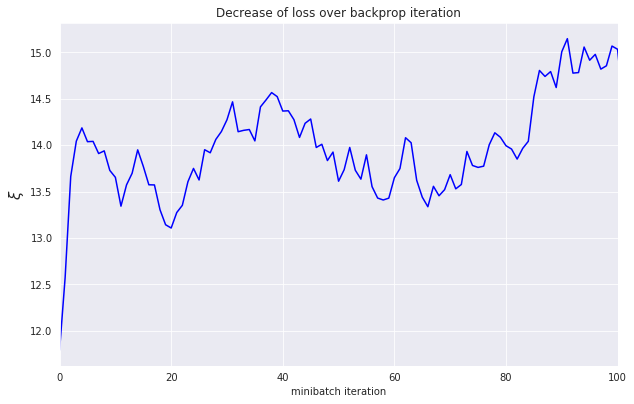

In [5]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(10, 7))
plt.plot(ls_of_loss, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [6]:
# Do gradient checking
# Define an RNN to test
#RNN = RnnBinaryAdder(2, 1, 3, sequence_len)
RNN = RnnBinaryAdder(1, max_num+1, hidden_size, seq_length)
# Get the gradients of the parameters from a subset of the data
backprop_grads = RNN.getParamGrads(
    x_train[0:100,:,:], y_train[0:100,:,:])

eps = 1e-7  # Set the small change to compute the numerical gradient
# Compute the numerical gradients of the parameters in all layers.
for p_idx, param in enumerate(RNN.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    param += eps
    plus_loss = RNN.loss(
        RNN.getOutput(x_train[0:100,:,:]), y_train[0:100,:,:])
    # - eps
    param -= 2 * eps
    min_loss = RNN.loss(
        RNN.getOutput(x_train[0:100,:,:]), y_train[0:100,:,:])
    # reset param value
    param += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to the 
    #  backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Numerical gradient of {grad_num:.6f} is not close '
            f'to the backpropagation gradient of {grad_backprop:.6f}!'
        ))
print('No gradient errors found')

ValueError: Numerical gradient of -0.285687 is not close to the backpropagation gradient of -8.153993!

In [ ]:
# TODO: unstable loss
# TODO: gradient checking
# TODO: fix gradient of loss function
# TODO: find where is gradient of activation function
# TODO: model predicts equal probabilities ???

In [8]:
RNN.getOutput(X_mb)

array([[[0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104]],

       [[0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104],
        [0.48878857, 0.05488421, 0.04076582, 0.27676036, 0.13880104]],

       [[0.48878